In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
chicago = pd.read_csv('/content/drive/MyDrive/final_csv/chicago_with_distance.csv')

In [4]:
chicago.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'geometry', 'Community Area Name', 'F_Date', 'Time',
       'High Risk Area', 'Hour', 'Weekday', 'Month',
       'Dist_to_Nearest_HighRisk'],
      dtype='object')

- 'Location Description' + 'Primary Type' 조합의 체포율(LocCrime_ArrestRate)을 수치형 피처로 추가

In [4]:
# 체포율 계산
grouped_arrest_rate = (
    chicago.groupby(['Location Description', 'Primary Type'])['Arrest']
    .mean()
    .reset_index()
    .rename(columns={'Arrest': 'LocCrime_ArrestRate'})
)

In [5]:
# 원래 데이터에 병합
chicago = pd.merge(chicago, grouped_arrest_rate,how='left', on=['Location Description', 'Primary Type'])

In [6]:
features_with_rate = [
    'Primary Type', 'Description', 'Location Description',
    'Community Area', 'Domestic', 'Hour', 'Weekday', 'Month',
    'Latitude', 'Longitude', 'Dist_to_Nearest_HighRisk','LocCrime_ArrestRate'
]

target = 'Arrest'

In [7]:
# 결측치 제거
ml_data = chicago[features_with_rate + [target]].dropna()

# 인코딩
from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in features_with_rate:
    if ml_data[col].dtype == 'object':
        le = LabelEncoder()
        ml_data[col] = le.fit_transform(ml_data[col])
        le_dict[col] = le

In [8]:
# X, y 분리
X_data = ml_data.drop(columns=[target])
y_data = ml_data[target]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.3,
                                                    stratify=y_data,
                                                    random_state=42)

In [10]:
# SMOTE는 훈련 데이터에만 적용!
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [11]:
from collections import Counter
# 클래스 분포 확인
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({False: 4312884, True: 1471089})
After SMOTE: Counter({True: 4312884, False: 4312884})


- 랜덤 포레스트

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 모델 생성
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# 모델 학습
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [14]:
# 테스트 예측
y_pred = rf_model.predict(X_test)

# 평가
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

정확도 (Accuracy): 0.8770661832158997

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.90      0.94      0.92   1848379
        True       0.80      0.69      0.74    630467

    accuracy                           0.88   2478846
   macro avg       0.85      0.82      0.83   2478846
weighted avg       0.87      0.88      0.87   2478846


혼동 행렬 (Confusion Matrix):
 [[1736187  112192]
 [ 192542  437925]]


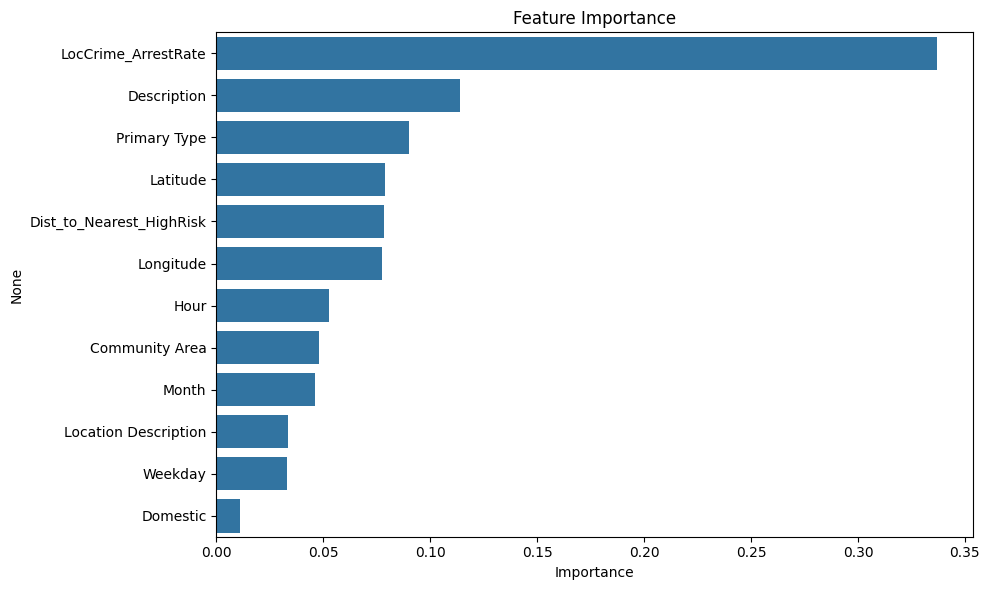

In [16]:
# 중요 피처 추출
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

- ligt gbm

In [17]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# 모델 학습
lgb_model.fit(X_resampled, y_resampled)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4312884, number of negative: 4312884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 8625768, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(n_jobs=-1, random_state=42)

In [19]:
# 예측
y_pred_lgb = lgb_model.predict(X_test)
# 평가
print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_lgb))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred_lgb))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred_lgb))

정확도 (Accuracy): 0.8663228776616215

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

       False       0.90      0.92      0.91   1848379
        True       0.75      0.72      0.73    630467

    accuracy                           0.87   2478846
   macro avg       0.83      0.82      0.82   2478846
weighted avg       0.86      0.87      0.87   2478846


혼동 행렬 (Confusion Matrix):
 [[1695425  152954]
 [ 178411  452056]]


| 모델                      | Accuracy | Recall (체포) | f1-score (체포) | 특징                                      |
|---------------------------|----------|----------------|------------------|-------------------------------------------|
| Random Forest (기존)   | 0.8771   | 0.69           | 0.74             | 가장 안정적인 성능, recall/precision 균형 |
| LightGBM (지금)         | 0.8663   | 0.72           | 0.73             | recall 높음, 약간의 정확도 손해           |

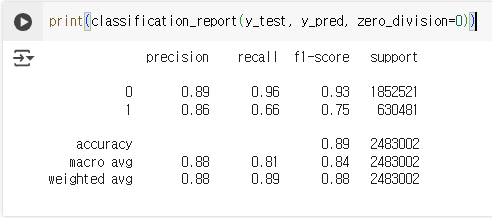

In [24]:
chicago.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,geometry,Community Area Name,F_Date,Time,High Risk Area,Hour,Weekday,Month,Dist_to_Nearest_HighRisk,LocCrime_ArrestRate
0,6255892,HP342049,2008-05-17 18:00:00,101XX S LAFAYETTE AVE,031A,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,...,POINT (-87.62479561 41.710039855),Roseland,2008-05-17,18:00:00,True,18,5,5,0.702878,0.101647
1,6272641,HP358387,2008-05-27 01:00:00,105XX S PERRY AVE,0320,ROBBERY,STRONG ARM - NO WEAPON,STREET,False,True,...,POINT (-87.625784664 41.703006756),Roseland,2008-05-27,01:00:00,True,1,1,5,0.147498,0.067890
2,6438609,HP496499,2008-08-05 22:37:00,126XX S UNION AVE,031A,ROBBERY,ARMED - HANDGUN,SCHOOL - PUBLIC GROUNDS,False,False,...,POINT (-87.639053139 41.664425476),West Pullman,2008-08-05,22:37:00,True,22,1,8,1.381272,0.056338
3,6680276,HP754070,2008-12-27 20:00:00,058XX N MANTON AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - GARAGE,False,False,...,POINT (-87.770650405 41.9873259),Jefferson Park,2008-12-27,20:00:00,False,20,5,12,10.525893,0.048836
4,12536164,JE439378,2015-09-24 00:00:00,031XX W 53RD PL,1753,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,APARTMENT,False,True,...,POINT (-87.702253422 41.796278388),Gage Park,2015-09-24,00:00:00,False,0,3,9,2.540790,0.226013


➡️ 데이터 리키지(data leakage)

 **테스트셋의 정답(Arrest)**까지 포함해서 계산했기 때문에


모델이 "미래를 미리 본 것처럼" 학습하게 되는 리키지 상황!

➞ 다른 값이 타겟일 땐 사용가능하니 남겨놓겠음